<a href="https://colab.research.google.com/github/vedasunkara/EBUReproducibilityChallenge/blob/master/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Veda attempts to make a GAN that works

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load the Pandas libraries with alias 'pd' 
import pandas as pd 
import numpy as np

# parse data from csv
def process_data():
  # x-values
  headers = ["age", "workclass", "fnlwgt", "education", "education-num",
             "marital-status", "occupation", "relationship", "race",
             "sex", "capital-gain", "capital-loss", "hours-per-week",
             "native-country", "wage"]

  df = pd.read_csv('/content/drive/Shared drives/RL Research (Veda & Naveen)/adult.data', names=headers, delim_whitespace=True, index_col=False)
  
  def normalize(df):
    return (df - df.mean()) / (df.max() - df.min())

  df["age"] = df["age"].astype('category').cat.codes
  normalized_age = normalize(df["age"])
  df = df.drop("age", axis=1)
  df = df.join(normalized_age)

  df["workclass"] = df["workclass"].astype('category').cat.codes
  one_hot_workclass = pd.get_dummies(df["workclass"])
  df = df.drop("workclass", axis=1)
  df = df.join(one_hot_workclass)

  df["fnlwgt"] = df["fnlwgt"].astype('category').cat.codes
  normalized_fnlwgt = normalize(df["fnlwgt"])
  df = df.drop("fnlwgt", axis=1)
  df = df.join(normalized_fnlwgt)

  df["education"] = df["education"].astype('category').cat.codes
  one_hot_education = pd.get_dummies(df["education"])
  df = df.drop("education", axis=1)
  df = df.join(one_hot_education, rsuffix='_right')

  df["education-num"] = df["education-num"].astype('category').cat.codes
  normalized_education = normalize(df["education-num"])
  df = df.drop("education-num", axis=1)
  df = df.join(normalized_education)

  df["marital-status"] = df["marital-status"].astype('category').cat.codes
  one_hot_marraige = pd.get_dummies(df["marital-status"])
  df = df.drop("marital-status", axis=1)
  df = df.join(one_hot_marraige, rsuffix='_right')

  df["occupation"] = df["occupation"].astype('category').cat.codes
  one_hot_job = pd.get_dummies(df["occupation"])
  df = df.drop("occupation", axis=1)
  df = df.join(one_hot_job, rsuffix='_right')

  df["relationship"] = df["relationship"].astype('category').cat.codes
  one_hot_relationship = pd.get_dummies(df["relationship"])
  df = df.drop("relationship", axis=1)
  df = df.join(one_hot_relationship, rsuffix='_right')

  df["race"] = df["race"].astype('category').cat.codes
  one_hot_race = pd.get_dummies(df["race"])
  df = df.drop("race", axis=1)
  df = df.join(one_hot_race, rsuffix='_right')

  df["sex"] = df["sex"].astype('category').cat.codes
  one_hot_sex = pd.get_dummies(df["sex"])
  one_hot_sex = one_hot_sex.rename(columns={0: "naveen", 1: "veda"})
  df = df.drop("sex", axis=1)
  df = df.join(one_hot_sex, rsuffix='_right')

  df["capital-gain"] = df["capital-gain"].astype('category').cat.codes
  normalized_gain = normalize(df["capital-gain"])
  df = df.drop("capital-gain", axis=1)
  df = df.join(normalized_gain)

  df["capital-loss"] = df["capital-loss"].astype('category').cat.codes
  normalized_loss = normalize(df["capital-loss"])
  df = df.drop("capital-loss", axis=1)
  df = df.join(normalized_loss)

  df["hours-per-week"] = df["hours-per-week"].astype('category').cat.codes
  normalized_hours = normalize(df["hours-per-week"])
  df = df.drop("hours-per-week", axis=1)
  df = df.join(normalized_hours)

  df["native-country"] = df["native-country"].astype('category').cat.codes
  one_hot_country = pd.get_dummies(df["native-country"])
  df = df.drop("native-country", axis=1)
  df = df.join(one_hot_country, rsuffix='_right')

  x_vals = df.drop("wage", axis = 1)

  # original values
  y_vals = df["wage"].astype('category').cat.codes
  y_vals = y_vals.fillna({"wage": -1})

  return x_vals, y_vals, x_vals['veda']

# process data to just get women who make > 50k
def get_data():
  x, y, _ = process_data()
  x = x.to_numpy()
  y = y.to_numpy()
  
  training_inputs = []
  training_labels = []
  
  # only get data for women who make > 50K
  for i in range(len(x)):
    if(x[i, 67] == 0 and y[i] == 1):
      training_inputs.append(x[i])
      training_labels.append(y[i])
     
  return np.array(training_inputs), np.array(training_labels)

# process_data()

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class GAN():
  def __init__(self):
    self.latent_dim = 100
    self.output_dim = 108
    self.num_classes = 2
    
    self.optimizer = Adam(0.001)
    
    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss=['binary_crossentropy'], optimizer=self.optimizer, metrics=['accuracy'])
    
    # Build the generator
    self.generator = self.build_generator()
    
    # generator takes in noise and generates a 14-pt feature vector for a person
    noise = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,))
    output = self.generator([noise, label])
    
    # determine the validity of the output using the discriminator
    valid = self.discriminator([output, label])
    
    # combine generator and discriminator to train together
    self.combined = Model([noise, label], valid)
    self.combined.compile(loss=['binary_crossentropy'], optimizer=self.optimizer)

  def build_generator(self):
    model = Sequential()
    
    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.output_dim), activation='tanh'))
    model.add(Reshape((self.output_dim,)))
    
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

    model_input = multiply([noise, label_embedding])
    output = model(model_input)
    
    return Model([noise, label], output)
  
  def build_discriminator(self):
    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(self.output_dim)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    
    inp = Input(shape=(self.output_dim,))
    
    # label is 0 or 1, =< or > 50K
    label = Input(shape=(1,), dtype='int32')
    
    label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.output_dim))(label))

    model_input = multiply([inp, label_embedding])
    validity = model(model_input)
    
    return Model([inp, label], validity)
  
  def generate_data(self, num_datapoints=1000):
    noise = np.random.normal(0, 1, (num_datapoints, 100))
    labels = np.ones(num_datapoints)
    
    return self.generator.predict([noise, labels]), labels
    
  def train(self, epochs, batch_size=128):
    x_train, y_train = get_data()
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
      # train the discriminator
      idx = np.random.randint(0, np.shape(x_train)[0], batch_size)
      inputs, labels = np.take(x_train, idx, axis=0), np.take(y_train, idx)
      
      # Sample noise as generator input
      noise = np.random.normal(0, 1, (batch_size, 100))

      # Generate a half batch of new images
      gen_data = self.generator.predict([noise, labels])

      # Train the discriminator
      d_loss_real = self.discriminator.train_on_batch([inputs, labels], valid)
      d_loss_fake = self.discriminator.train_on_batch([gen_data, labels], fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      
      #train generator
      # Condition on labels
      sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

      # Train the generator
      g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

      # Plot the progress
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))


gan = GAN()

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               55808     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply

class PredictionModel():
  def __init__(self):
    self.b_size = 32
    self.input_dim = 108
    self.model = self.build_model()
  
  def build_model(self):
    model = Sequential()
    model.add(Dense(32, input_dim=self.input_dim, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation="softmax"))
    
    model.summary()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy', 
        metrics=['accuracy'],
    )

    return model

  def train(self, inputs, labels, inputs_test, labels_test):
    self.model.fit(inputs, labels, batch_size=64, epochs=1, validation_data=(inputs_test, labels_test))
  
  def test(self, inputs):
    return self.model.predict_proba(inputs)

Loop, based on KL-divergence, and generate fake data as necessary

In [0]:
def bin_probabilities(predictions, gender):
  sex_m_x = np.zeros(10)
  sex_f_x = np.zeros(10)
  
  for i in range(predictions.shape[0]):
    pred = predictions[i][1] #grab probability that individual earning more than 50K
    loc = 0
    if (pred <= .1):
      loc = 0
    elif (pred <= .2):
      loc = 1
    elif (pred <= .3):
      loc = 2
    elif (pred <= .4):
      loc = 3
    elif (pred <= .5):
      loc = 4
    elif (pred <= .6):
      loc = 5
    elif (pred <= .7):
      loc = 6
    elif (pred <= .8):
      loc = 7
    elif (pred <= .9):
      loc = 8
    else:
      loc = 9
    if (gender[i] == 1): #one means man
      sex_m_x[loc] = sex_m_x[loc] + 1
    else:
      sex_f_x[loc] = sex_f_x[loc] + 1

  return sex_m_x, sex_f_x

def kl_divergence(p, q):
    #input: histogram distributions of probability counts, 10 bins from [0, 1]
    #output: kullbach-leibler divergence D(p || q)

    #first, we normalize the counts distribution to create a pmf (probability mass function)
    p_pmf = p/np.sum(p)
    q_pmf = q/np.sum(q)

    #second, we compute the kullbach-leibler divergence
    return np.sum(np.where(p_pmf != 0, p_pmf * np.log(p_pmf / q_pmf), 0))

In [0]:
from keras.utils import to_categorical

def fit_curves(gan, model, x_train, y_train, gender_labels):
  epsilon = 0.1
  num_additions = 1000
  divergence = 1 
  
  current_values = model.test(x_train)
  mp, fp = bin_probabilities(current_values, gender_labels)
  print("BEFORE")
  print(mp)
  print(fp)

  x_test = x_train
  y_test = y_train
  
  num_iters = 204
  divergence_vals = np.zeros(num_iters)
  #while divergence > epsilon:
  for i in range(num_iters):
    # generate fake data
    new_x, new_y = gan.generate_data(num_additions)
    new_y = to_categorical(new_y)

    # supplement x_train
    x_train = np.append(x_train, new_x, axis=0)
    y_train = np.append(y_train, new_y, axis=0)

    # retrain model
    model.train(x_train, y_train, x_test, y_test)
    
    # generate new curves
    predictions = model.test(x_test)

    # bin prediction values to create discrete count distribution
    male_probabilities, female_probabilities = bin_probabilities(predictions, gender_labels)

    # recalculate divergence
    divergence = kl_divergence(male_probabilities, female_probabilities)
    divergence_vals[i] = divergence
    
    # reset points
    current_values = predictions
  
  print("AFTER")
  pred = model.test(x_test)
  mpa, fpa = bin_probabilities(pred, gender_labels)
  print(mpa)
  print(fpa)
  print(divergence_vals)

if __name__ == '__main__':
    x_train, y_train, gender_labels = process_data()
    y_train = to_categorical(y_train)

    gan.train(epochs=100, batch_size=100)
    
    model = PredictionModel()
    model.train(x_train, y_train, x_train, y_train)

    fit_curves(gan, model, x_train, y_train, gender_labels)

0 [D loss: 0.360994, acc.: 82.50%] [G loss: 0.811080]
1 [D loss: 0.383224, acc.: 79.50%] [G loss: 0.830939]
2 [D loss: 0.325848, acc.: 84.50%] [G loss: 0.865797]
3 [D loss: 0.337978, acc.: 86.00%] [G loss: 0.886582]
4 [D loss: 0.350713, acc.: 84.50%] [G loss: 0.864081]
5 [D loss: 0.352703, acc.: 84.50%] [G loss: 0.763999]
6 [D loss: 0.352071, acc.: 83.00%] [G loss: 0.825192]
7 [D loss: 0.385996, acc.: 77.50%] [G loss: 0.832678]
8 [D loss: 0.330876, acc.: 87.00%] [G loss: 0.818205]
9 [D loss: 0.335974, acc.: 88.00%] [G loss: 0.886918]
10 [D loss: 0.351367, acc.: 84.50%] [G loss: 0.930830]
11 [D loss: 0.327271, acc.: 83.50%] [G loss: 0.878874]
12 [D loss: 0.304768, acc.: 90.50%] [G loss: 0.871836]
13 [D loss: 0.351573, acc.: 82.00%] [G loss: 0.867025]
14 [D loss: 0.417259, acc.: 71.00%] [G loss: 0.844203]
15 [D loss: 0.339024, acc.: 84.50%] [G loss: 0.887761]
16 [D loss: 0.344979, acc.: 82.50%] [G loss: 0.885757]
17 [D loss: 0.322964, acc.: 86.00%] [G loss: 0.919067]
18 [D loss: 0.322219

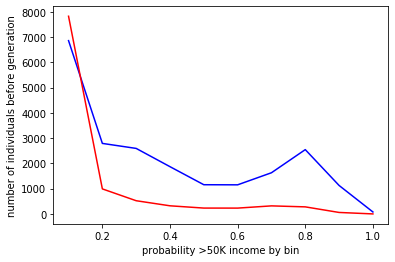

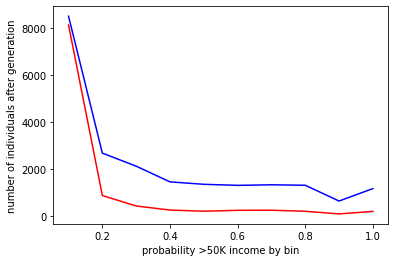

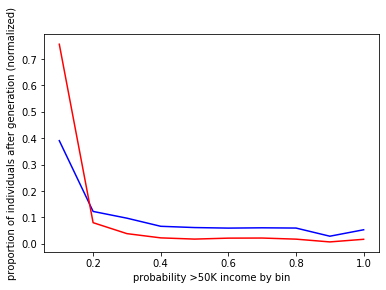

In [0]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.zeros(10)
for i in range(len(bins)):
  bins[i] = 0.1*i + 0.1

# PLOT BEFORE DATA GENERATION
male_before = [6857., 2790., 2592., 1869., 1155., 1151., 1629., 2544., 1126.,   77.]
female_before = [7822.,  990.,  522.,  321.,  231.,  230.,  318.,  279.,   58.,    0.]

plt.xlabel("probability >50K income by bin")
plt.ylabel("number of individuals before generation")

plt.plot(bins, male_before, color="blue")
plt.plot(bins, female_before, color="red")
plt.show()

# PLOT AFTER DATA GENERATION
plt.xlabel("probability >50K income by bin")
plt.ylabel("number of individuals after generation")

male_after = [8515., 2672., 2115., 1445., 1341., 1296., 1320., 1300.,  627., 1159.]
female_after = [8143.,  862.,  415.,  242.,  192.,  231.,  235.,  190.,   77.,  184.]
plt.plot(bins, male_after, color="blue")
plt.plot(bins, female_after, color="red")
plt.show()

# PLOT WITH NORMALIZED VALUES AFTER DATA GENERATION
plt.xlabel("probability >50K income by bin")
plt.ylabel("proportion of individuals after generation (normalized)")

male_after_norm = np.array(male_after) / np.array(male_after).sum()
female_after_norm = np.array(female_after) / np.array(female_after).sum()

plt.plot(bins, male_after_norm, color="blue")
plt.plot(bins, female_after_norm, color="red")
plt.show()
